# 1. Import Library

In [34]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Write Function

In [35]:
# Random ค่า Weight และ bias (กรณีโจรทย์ไม่ได้กำหนดให้)
def NN_create_WB(A0, HL):
    W = []
    B = []
    for i in range(len(HL)):
        if i == 0: #Layer แรก (Input)
            W_i = np.random.randn(A0.shape[1], HL[0])/np.sqrt(HL[0]) # matrix (A0.shape[1], HL[0]) หารจำนวน Layer ทั้งหมด np.sqrt(HL[0])
        else:
            W_i = np.random.randn(HL[i-1], HL[i])/np.sqrt(HL[i]) #HL[i-1] Layerก่อนหน้า
        
        B_i = np.random.randn(1, HL[i])/np.sqrt(HL[i])
        W.append(W_i)
        B.append(B_i)
    return W, B

In [36]:
#=================== Regression =======================#
def NNR_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        
        #------- forward ---------#
        Z, A = NN_forward(A0, W, B, AF)
        error = find_error(T, A[-1], 'SSE') #เทียบคำตอบจริง(T) กับค่าที่ได้ใน node Layer A
        error_list.append(error) #Add matraix ใน error_list
        
        #----- backpropagation ----#
        #---- W(m) = W(m) + ( (α/N) * A(m-1)^T *Err(m)) -----#
        SW, SB = NNR_backpropagation(A0, W, B, Z, A, T, AF)
        for j in range(L):
            W[j] = W[j] + (lr/N)*SW[j] # W(m) = W(m) + (α* A(m-1)^T *Err(m))/N
            B[j] = B[j] + (lr/N)*SB[j] # B(m) = B(m) + (α* Err(m).sum(axis=0))/N
            
    return W, B, error_list

In [37]:
#============== Classification (Error -> Entropy) ====================#
def NNC_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        
        #------- forward ---------#
        Z, A = NN_forward(A0, W, B, AF)
        error = find_error(T, A[-1], 'Entropy') #เทียบคำตอบจริง(T) กับค่าที่ได้ใน node Layer A
        error_list.append(error) #Add matraix ใน error_list
        
        #----- backpropagation ----#
        #---- W(m) = W(m) + ( (α/N) * A(m-1)^T *Err(m)) -----#
        SW, SB = NNC_backpropagation(A0, W, B, Z, A, T, AF)
        for j in range(L):
            W[j] = W[j] + (lr/N)*SW[j] # W(m) = W(m) + (α* A(m-1)^T *Err(m))/N
            B[j] = B[j] + (lr/N)*SB[j] # B(m) = B(m) + (α* Err(m).sum(axis=0))/N
            
    return W, B, error_list

In [38]:
def NN_forward(A0, W, B, AF):
    Z = []
    A = []
    for i in range(len(AF)):
        
        if i == 0: #Layer แรก (Input)
            Z_i = np.dot(A0, W[i]) + B[i] #A0W1 + B1
        else: #Layer ถัดๆไป
            Z_i = np.dot(A[-1], W[i]) + B[i]
            
        A_i = NN_compute_A(Z_i, AF[i]) #Activation function
        Z.append(Z_i)
        A.append(A_i)
    return Z, A

In [39]:
#Activation function
def NN_compute_A(Z_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            A_i = 1/(1 + np.exp(-Z_i))
        elif af == 'tanh':
            A_i = (np.exp(Z_i) - np.exp(-Z_i))/(np.exp(Z_i) + np.exp(-Z_i))
        elif af == 'ReLU':
            A_i = Z_i * (Z_i > 0)
        elif af == 'softmax':
            A_i = np.exp(Z_i)/np.exp(Z_i).sum(axis=1, keepdims = True)
    elif type(af) == list:
        if af[0] == 'PReLU':
            A_i = Z_i * (Z_i > 0) + af[1] * Z_i * (Z_i <= 0)
    return A_i

In [40]:
#=================== Regression =======================#
#---- W(m) = W(m) + (α* A(m-1)^T *Err(m))/N -----#
def NNR_backpropagation(A0, W, B, Z, A, T, AF):
    L = len(AF)
    SW = []
    SB = []
    for i in range(L - 1, -1, -1): #ย้อนกลับทีละหนึ่ง Step หลังไปหน้า (out -> in) (-1)
        if i == L - 1:
            Delta_i = T - A[i] #layer แรก (output) δ(m) = T - A(m)
        else:
            Delta_i = np.dot(Err_i, W[i+1].T) # δ(m) = Err(m+1)*W(m+1)^T
            
        Diff_i = NN_compute_Diff(Z[i], A[i], AF[i]) # Diff -> Activation function
        Err_i = NN_compute_Err(Delta_i, Diff_i) #Err(m+1) = δ(m) * Diff(m)
        
        #---- W(m) ---#
        if i != 0:
            SW_i = np.dot(A[i-1].T, Err_i) #layer ต่อๆมา # W(m) = A(m-1)^T *Err(m)
        else:
            SW_i = np.dot(A0.T, Err_i) #layer แรก (output) # W(1) = A(0)^T *Err(1)
        
        SB_i = Err_i.sum(axis=0) #รวมกันแนวตั้ง
        SW.append(SW_i) # Err_i -> SW_i -> SW -> W(m) or Wight
        SB.append(SB_i) # bias
    return SW[::-1], SB[::-1] # -1 กลับด้าน Array matrix ให้เรียง forward

In [41]:
#---- W(m) = W(m) + (α* A(m-1)^T *Err(m))/N -----#
def NNC_backpropagation(A0, W, B, Z, A, T, AF):
    L = len(AF)
    SW = []
    SB = []
    for i in range(L - 1, -1, -1):  #ย้อนกลับทีละหนึ่ง Step หลังไปหน้า (out -> in) (-1)
        
        if i == L - 1:
            Delta_i = T - A[i] #layer แรก (output) δ(m) = T - A(m)
            Diff_i = 1         # Diff_i = 1 ตามการ Diff simoid function ใน layer แรก (output)
        else:
            Delta_i = np.dot(Err_i, W[i+1].T)  # δ(m) = Err(m+1)*W(m+1)^T
            Diff_i = NN_compute_Diff(Z[i], A[i], AF[i])  # Diff -> Activation function       
        
        Err_i = NN_compute_Err(Delta_i, Diff_i) #Err(m+1) = δ(m) * Diff(m)
        
        #---- W(m) ---#
        if i != 0:
            SW_i = np.dot(A[i-1].T, Err_i) #layer ต่อๆมา # W(m) = A(m-1)^T *Err(m)
        else:
            SW_i = np.dot(A0.T, Err_i) #layer แรก (output) # W(1) = A(0)^T *Err(1)
        
        SB_i = Err_i.sum(axis=0) #รวมกันแนวตั้ง
        SW.append(SW_i) # Err_i -> SW_i -> SW -> W(m) or Wight
        SB.append(SB_i) # bias
    return SW[::-1], SB[::-1] # -1 กลับด้าน Array matrix ให้เรียง forward

In [42]:
# Diff -> Activation function
def NN_compute_Diff(Z_i, A_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            Diff_i = A_i * (1 - A_i)
        elif af == 'tanh':
            Diff_i = 1 - A_i**2
        elif af == 'ReLU':
            Diff_i = (Z_i > 0)
    elif type(af) == list:
        if af[0] == 'PReLU':
            Diff_i = (Z_i > 0) + af[1] * (Z_i <= 0)
    return Diff_i

In [43]:
#Err(m) = δ(m) * Diff(m)
def NN_compute_Err(Delta_i, Diff_i):
    Err_i = Delta_i * Diff_i
    return Err_i

In [44]:
def find_error(Y, Yhat, TypeOfError):
    if TypeOfError == 'SSE':
        error = find_SSE(Y, Yhat)
    elif TypeOfError == 'MSE':
        error = find_MSE(Y, Yhat)
    elif TypeOfError == 'MAE':
        error = find_MAE(Y, Yhat)
    elif TypeOfError == 'MAPE':
        error = find_MAPE(Y, Yhat)
        
    #========== Classification ============#  
    elif TypeOfError == 'Entropy': 
        error = find_Entropy(Y, Yhat)
        #---------- Binary (0,1) ----------#  
    elif TypeOfError == 'Binary':
        error = find_error_bin_class(Y, Yhat)
        #--------- Multiclass -------------#    
    elif TypeOfError == 'Multiclass':
        error = find_error_mul_class(Y, Yhat)
    #======================================#
    return error

In [45]:
def find_SSE(Y, Yhat):
    SSE = ((Y - Yhat)**2).sum()
    return SSE

In [46]:
def find_MSE(Y, Yhat):
    N = Y.shape[0]
    SSE = ((Y - Yhat)**2).sum()
    MSE = SSE/N
    return MSE

In [47]:
def find_MAE(Y, Yhat):
    N = Y.shape[0]
    MAE = (np.abs(Y - Yhat)).sum()/N
    return MAE

In [48]:
def find_MAPE(Y, Yhat):
    N = Y.shape[0]
    MAPE = np.abs((Y - Yhat)/Y).sum()*100/N
    return MAPE

In [49]:
def find_Entropy(Y, Yhat):
    error = (-Y*np.log(Yhat)).sum()
    return error

In [50]:
def find_error_bin_class(Y, Yhat):
    N = Y.shape[0]
    _Y = np.round(Y, 0)
    _Yhat = np.round(Yhat, 0)
    error = 100*(_Y != _Yhat).sum()/N
    return error

In [51]:
def find_error_mul_class(Y, Yhat):
    N = Y.shape[0]
    Y_argmax = np.argmax(Y, axis=1)
    Yhat_argmax = np.argmax(Yhat, axis=1)
    error = 100*(Y_argmax != Yhat_argmax).sum()/N
    return error

# 3. Normalization

In [52]:
def min4norm(Data):
    _min = Data.min(axis=0)
    return _min.reshape(1, -1)

In [53]:
def max4norm(Data):
    _max = Data.max(axis=0)
    return _max.reshape(1, -1)

In [54]:
def mean4norm(Data):
    _mean = Data.mean(axis=0)
    return _mean.reshape(1, -1)

In [55]:
def std4norm(Data):
    _std = Data.std(axis=0)
    return _std.reshape(1, -1)

In [56]:
def ed4norm(Data):
    _ed = np.sqrt((Data**2).sum(axis=0))
    return _ed.reshape(1, -1)

In [57]:
def minmaxNorm(Data, min_norm, max_norm):
    Data_Norm = (Data - min_norm)/(max_norm - min_norm)
    return Data_Norm

In [58]:
def meanNorm(Data, min_norm, max_norm, mean_norm):
    Data_Norm = (Data - mean_norm)/(max_norm - min_norm)
    return Data_Norm

In [59]:
def standardization(Data, mean_norm, std_norm):
    Data_Norm = (Data - mean_norm)/std_norm
    return Data_Norm

In [60]:
def SUL(Data, ed_norm):
    Data_Norm = Data/ed_norm
    return Data_Norm

In [61]:
def de_minmaxNorm(Data_Norm, min_norm, max_norm):
    Data = Data_Norm*(max_norm - min_norm) + min_norm
    return Data

In [62]:
def de_meanNorm(Data_Norm, min_norm, max_norm, mean_norm):
    Data = Data_Norm*(max_norm - min_norm) + mean_norm
    return Data

In [63]:
def de_standardization(Data_Norm, mean_norm, std_norm):
    Data = Data_Norm*std_norm + mean_norm
    return Data

In [64]:
def de_SUL(Data_Norm, ed_norm):
    Data = Data_Norm*ed_norm
    return Data

# 4. Read Data & Prepare Data

In [65]:
#Data = pd.read_excel('EURUSD Close.xlsx', usecols = 'H:AL', skiprows = range(1, 32))
Data = pd.read_excel('EURUSD Close.xlsx', skiprows = range(1, 32), usecols=["Close 1", "Close 2", "Close 3", "Close 4","Close 5","Close 6","Close 7","Close 8","Close 9","Close 10","Close 11", "Close 12", "Close 13", "Close 14","Close 15","Close 16","Close 17","Close 18","Close 19","Close 20","Close 21", "Close 22", "Close 23", "Close 24","Close 25","Close 26","Close 27","Close 28","Close 29","Clsoe 30","Target Close"])


In [66]:
Data #Target Close ราคาปิดในวันที่เราสนใจ

,Close 1,Close 2,Close 3,Close 4,Close 5,Close 6,Close 7,Close 8,Close 9,Close 10,...,Close 22,Close 23,Close 24,Close 25,Close 26,Close 27,Close 28,Close 29,Clsoe 30,Target Close
0,1.18326,1.18600,1.17608,1.17391,1.16729,1.17131,1.16971,1.18375,1.16615,1.17361,...,1.15705,1.13847,1.14940,1.15120,1.15427,1.14877,1.14996,1.13647,1.14338,1.17907
1,1.17907,1.18326,1.18600,1.17608,1.17391,1.16729,1.17131,1.16971,1.18375,1.16615,...,1.16566,1.15705,1.13847,1.14940,1.15120,1.15427,1.14877,1.14996,1.13647,1.16853
2,1.16853,1.17907,1.18326,1.18600,1.17608,1.17391,1.16729,1.17131,1.16971,1.18375,...,1.17039,1.16566,1.15705,1.13847,1.14940,1.15120,1.15427,1.14877,1.14996,1.17173
3,1.17173,1.16853,1.17907,1.18326,1.18600,1.17608,1.17391,1.16729,1.17131,1.16971,...,1.16716,1.17039,1.16566,1.15705,1.13847,1.14940,1.15120,1.15427,1.14877,1.16010
4,1.16010,1.17173,1.16853,1.17907,1.18326,1.18600,1.17608,1.17391,1.16729,1.17131,...,1.16908,1.16716,1.17039,1.16566,1.15705,1.13847,1.14940,1.15120,1.15427,1.15399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4162,1.11678,1.11291,1.11310,1.11598,1.11910,1.12043,1.11815,1.11501,1.11604,1.11655,...,1.11714,1.11953,1.12145,1.11854,1.11429,1.11309,1.11519,1.12268,1.12566,1.12414
4163,1.12414,1.11678,1.11291,1.11310,1.11598,1.11910,1.12043,1.11815,1.11501,1.11604,...,1.12007,1.11714,1.11953,1.12145,1.11854,1.11429,1.11309,1.11519,1.12268,1.12515
4164,1.12515,1.12414,1.11678,1.11291,1.11310,1.11598,1.11910,1.12043,1.11815,1.11501,...,1.11980,1.12007,1.11714,1.11953,1.12145,1.11854,1.11429,1.11309,1.11519,1.12208
4165,1.12208,1.12515,1.12414,1.11678,1.11291,1.11310,1.11598,1.11910,1.12043,1.11815,...,1.11912,1.11980,1.12007,1.11714,1.11953,1.12145,1.11854,1.11429,1.11309,1.12753


In [67]:
DataMatrix = Data.values

In [68]:
DataMatrix.shape

(4167, 31)

In [69]:
D = DataMatrix.shape[1] - 1 #.shape[1] colunm (-1 ตัด Target Close)
D

30

In [70]:
A0 = DataMatrix[:, :D]
A0

array([[1.18326, 1.186  , 1.17608, ..., 1.14996, 1.13647, 1.14338],
       [1.17907, 1.18326, 1.186  , ..., 1.14877, 1.14996, 1.13647],
       [1.16853, 1.17907, 1.18326, ..., 1.15427, 1.14877, 1.14996],
       ...,
       [1.12515, 1.12414, 1.11678, ..., 1.11429, 1.11309, 1.11519],
       [1.12208, 1.12515, 1.12414, ..., 1.11854, 1.11429, 1.11309],
       [1.12753, 1.12208, 1.12515, ..., 1.12145, 1.11854, 1.11429]])

In [96]:
A0.shape

(4167, 30)

In [71]:
T = DataMatrix[:, D:]

In [72]:
A0.shape

(4167, 30)

In [73]:
T

array([[1.17907],
       [1.16853],
       [1.17173],
       ...,
       [1.12208],
       [1.12753],
       [1.13334]])

In [74]:
A0_Train = A0[:-150, :]  #X
T_Train = T[:-150, :]  #Y

In [75]:
A0_Test = A0[-150:, :]
T_Test = T[-150:, :]

# 5. Create Model

In [76]:
min_A0_Train = min4norm(A0_Train)
max_A0_Train = max4norm(A0_Train)
mean_A0_Train = mean4norm(A0_Train)
std_A0_Train = std4norm(A0_Train)
ed_A0_Train = ed4norm(A0_Train)

min_T_Train = min4norm(T_Train)
max_T_Train = max4norm(T_Train)
mean_T_Train = mean4norm(T_Train)
std_T_Train = std4norm(T_Train)
ed_T_Train = ed4norm(T_Train)

In [77]:
A0_Train_Norm = minmaxNorm(A0_Train, min_A0_Train, max_A0_Train)
# A0_Train_Norm = meanNorm(A0_Train, min_A0_Train, max_A0_Train, mean_A0_Train)
# A0_Train_Norm = standardization(A0_Train, mean_A0_Train, std_A0_Train)
# A0_Train_Norm = SUL(A0_Train, ed_A0_Train)

T_Train_Norm = minmaxNorm(T_Train, min_T_Train, max_T_Train)
# T_Train_Norm = meanNorm(T_Train, min_T_Train, max_T_Train, mean_T_Train)
# T_Train_Norm = standardization(T_Train, mean_T_Train, std_T_Train)
# T_Train_Norm = SUL(T_Train, ed_T_Train)

In [78]:
HL = [15, 15, 1]

In [79]:
AF = [['PReLU', 0.5], ['PReLU', 0.5], ['PReLU', 0.5]]

In [80]:
W, B, error_list = NNR_find_WB(A0_Train_Norm, T_Train_Norm, HL, AF, epoch = 40000, lr = 0.02)

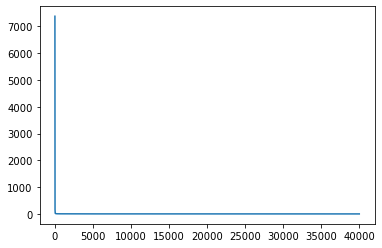

In [81]:
plt.plot(error_list)

In [82]:
Z_Train_Norm, A_Train_Norm = NN_forward(A0_Train_Norm, W, B, AF)

In [100]:
A_Train_Norm[-1]

array([[0.2515496 ],
       [0.2792767 ],
       [0.2853836 ],
       ...,
       [0.18534397],
       [0.18625671],
       [0.18276373]])

In [83]:
That_Train = de_minmaxNorm(A_Train_Norm[-1], min_T_Train, max_T_Train)
# That_Train = de_meanNorm(A_Train_Norm[-1], min_T_Train, max_T_Train, mean_T_Train)
# That_Train = de_standardization(A_Train_Norm[-1], mean_T_Train, std_T_Train)
# That_Train = de_SUL(A_Train_Norm[-1], ed_T_Train)

In [84]:
error_Train = find_error(T_Train, That_Train, 'MAPE') # Y ข้อมูลจริง เทียบ Yhat ที่ทำนายได้

In [85]:
error_Train

0.6469621306282959

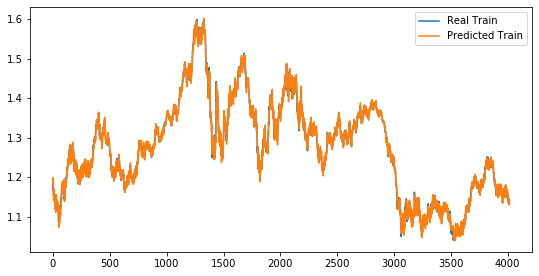

In [86]:
fig = plt.figure(figsize = (9, 4.5))
plt.plot(T_Train, label = 'Real Train')
plt.plot(That_Train, label = 'Predicted Train')
plt.legend()

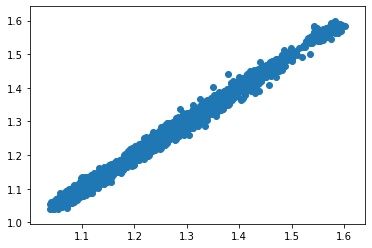

In [87]:
plt.scatter(That_Train, T_Train)

# 6. Make Prediction

In [88]:
A0_Test_Norm = minmaxNorm(A0_Test, min_A0_Train, max_A0_Train)
# A0_Test_Norm = meanNorm(A0_Test, min_A0_Train, max_A0_Train, mean_A0_Train)
# A0_Test_Norm = standardization(A0_Test, mean_A0_Train, std_A0_Train)
# A0_Test_Norm = SUL(A0_Test, ed_A0_Train)

T_Test_Norm = minmaxNorm(T_Test, min_T_Train, max_T_Train)
# T_Test_Norm = meanNorm(T_Test, min_T_Train, max_T_Train, mean_T_Train)
# T_Test_Norm = standardization(T_Test, mean_T_Train, std_T_Train)
# T_Test_Norm = SUL(T_Test, ed_T_Train)

In [89]:
Z_Test_Norm, A_Test_Norm = NN_forward(A0_Test_Norm, W, B, AF)

In [90]:
That_Test = de_minmaxNorm(A_Test_Norm[-1], min_T_Train, max_T_Train)
# That_Test = de_meanNorm(A_Test_Norm[-1], min_T_Train, max_T_Train, mean_T_Train)
# That_Test = de_standardization(A_Test_Norm[-1], mean_T_Train, std_T_Train)
# That_Test = de_SUL(A_Test_Norm[-1], ed_T_Train)

In [91]:
error_Test = find_error(T_Test, That_Test, 'MAPE')

In [92]:
error_Test

0.4094933934681992

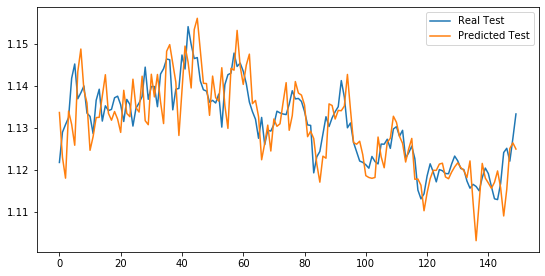

In [93]:
fig = plt.figure(figsize = (9, 4.5))
plt.plot(T_Test, label = 'Real Test')
plt.plot(That_Test, label = 'Predicted Test')
plt.legend()

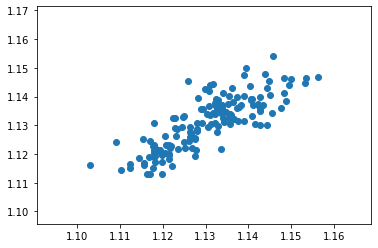

In [94]:
plt.scatter(That_Test, T_Test)

# 7. Zoom Result

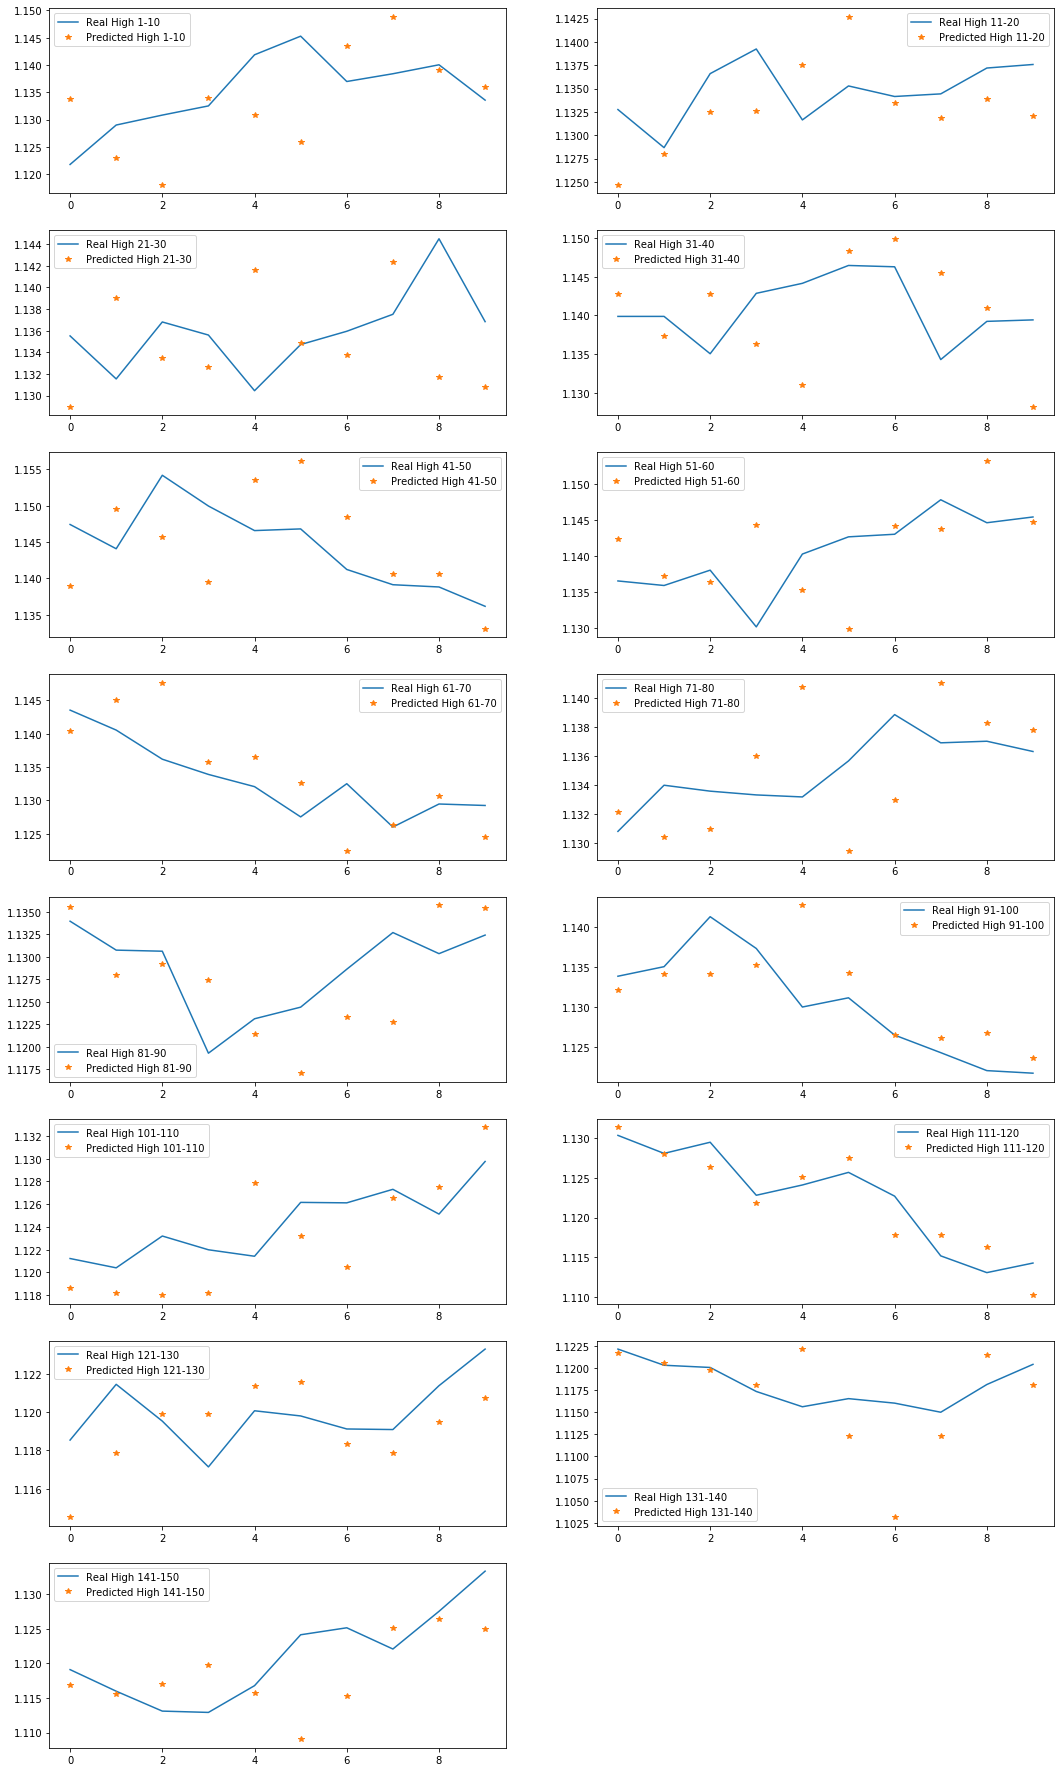

In [95]:
fig = plt.figure(figsize=(18, 32))

for i in range(15):
    plt.subplot(8, 2, i + 1)
    plt.plot(T_Test[10*i: 10*i + 10], label = 'Real High ' + str(i*10 + 1) + '-'  + str(i*10 + 10))
    plt.plot(That_Test[10*i: 10*i + 10], '*', label = 'Predicted High ' + str(i*10 + 1) + '-'  + str(i*10 + 10))
    plt.legend()